# Installing the necessary library

In [ ]:
!pip install split-folders
!pip install keras-tuner
!pip install torch torchvision tqdm
#!pip install tensorflow keras numpy pandas matplotlib scikit-learn pillow
# Install any library which are not available

In [ ]:
import os
import copy
import torch
import numpy as np
import pandas as pd
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager



In [ ]:
import random
import shutil
import splitfolders
from glob import glob
from sklearn.model_selection import train_test_split


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Inpu
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Model



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


<ipython-input-4-0001722f78e8>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
if "food-101" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2024-07-06 16:15:27--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-07-06 16:15:27--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  32.9MB/s    in 2m 30s  

2024-07-06 16:17:57 (31.8 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [ ]:
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

In [ ]:
!echo "Testing images"
!head -n 5 ./food-101/meta/test.txt
!echo -e "\nTraining images"
!head -n 5 ./food-101/meta/train.txt | head -n 5

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [ ]:
# Load classes and images
#classes = sorted(os.listdir('food-101/images'))
num_classes = len(classes)
print(f"Total number of classes: {num_classes}")

Total number of classes: 101


**Step 1: Select Random 25 Classes and Create Filtered Dataset Directory**

In [ ]:


# Assuming the dataset is unzipped and structured properly
data_dir = '/content/food-101/images'  # Update this path to your dataset location

# Get all class names
all_classes = os.listdir(data_dir)
print(f"Total number of classes: {len(all_classes)}")

# Select 25 random classes
random_classes = random.sample(all_classes, 25)
print(f"Selected classes: {random_classes}")

# Create filtered dataset directory
filtered_data_dir = '/content/filtered_images'
os.makedirs(filtered_data_dir, exist_ok=True)

for cls in random_classes:
    os.makedirs(os.path.join(filtered_data_dir, cls), exist_ok=True)
    images = os.listdir(os.path.join(data_dir, cls))
    for img in images:
        shutil.copy(os.path.join(data_dir, cls, img), os.path.join(filtered_data_dir, cls, img))

print("Filtered dataset directory created.")


Total number of classes: 101
Selected classes: ['pulled_pork_sandwich', 'chicken_wings', 'ravioli', 'pizza', 'tuna_tartare', 'miso_soup', 'beignets', 'caprese_salad', 'dumplings', 'chocolate_cake', 'garlic_bread', 'foie_gras', 'onion_rings', 'scallops', 'hot_and_sour_soup', 'shrimp_and_grits', 'omelette', 'eggs_benedict', 'spaghetti_bolognese', 'club_sandwich', 'frozen_yogurt', 'french_toast', 'fried_calamari', 'fried_rice', 'gnocchi']
Filtered dataset directory created.


**Splittin the dataset using  Train-Test Split**

In [ ]:

# Create train and test directories
train_dir = os.path.join(filtered_data_dir, 'train')
test_dir = os.path.join(filtered_data_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in random_classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    images = os.listdir(os.path.join(filtered_data_dir, cls))
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.move(os.path.join(filtered_data_dir, cls, img), os.path.join(train_dir, cls, img))
    for img in test_images:
        shutil.move(os.path.join(filtered_data_dir, cls, img), os.path.join(test_dir, cls, img))

print("Train-test split completed.")


Train-test split completed.


**Step 2: Load Dataset using tf.keras.utils.image_dataset_from_directory**

In [ ]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=img_size,
    seed=42,
    color_mode='rgb',
    shuffle=True,
    label_mode="categorical",
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=img_size,
    seed=42,
    color_mode='rgb',
    shuffle=True,
    label_mode="categorical",
    batch_size=batch_size
)

print("Training and validation datasets created.")


Found 20000 files belonging to 25 classes.
Found 5000 files belonging to 25 classes.
Training and validation datasets created.


# **EDA on training and testing dataset**


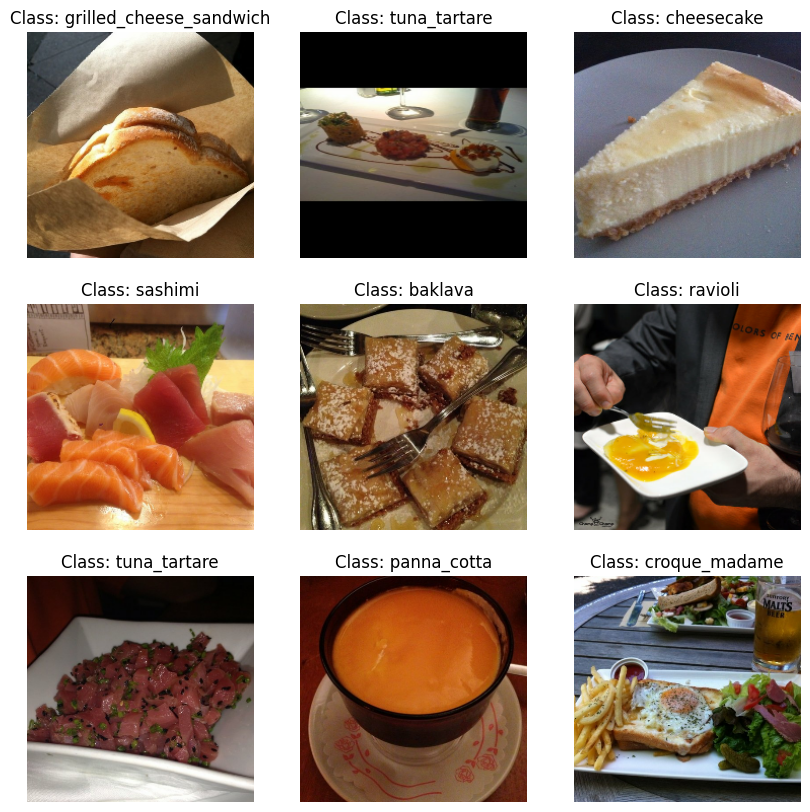

In [ ]:
# Ensure class_names is defined
class_names = train_ds.class_names

# Visualize Training Data
train_images, train_labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].numpy().astype("uint8"))
    plt.title(f"Class: {class_names[tf.argmax(train_labels[i]).numpy()]}")
    plt.axis("off")
plt.show()

# EDA: Looking the distribution of data

In [ ]:

def count_images_in_classes(directory):
    class_counts = {}
    for cls in os.listdir(directory):
        class_dir = os.path.join(directory, cls)
        if os.path.isdir(class_dir):
            class_counts[cls] = len(os.listdir(class_dir))
    return class_counts

# Count images in training and testing directories
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)

print("Number of images in each class (Training):")
print(train_class_counts)

print("\nNumber of images in each class (Testing):")
print(test_class_counts)


Number of images in each class (Training):
{'apple_pie': 800, 'spaghetti_bolognese': 800, 'chocolate_mousse': 800, 'chicken_curry': 800, 'gyoza': 800, 'french_fries': 800, 'carrot_cake': 800, 'frozen_yogurt': 800, 'french_onion_soup': 800, 'oysters': 800, 'scallops': 800, 'mussels': 800, 'paella': 800, 'crab_cakes': 800, 'shrimp_and_grits': 800, 'falafel': 800, 'pancakes': 800, 'caesar_salad': 800, 'creme_brulee': 800, 'escargots': 800, 'tiramisu': 800, 'lobster_roll_sandwich': 800, 'bruschetta': 800, 'lobster_bisque': 800, 'grilled_salmon': 800, 'cannoli': 800, 'filet_mignon': 800, 'spaghetti_carbonara': 800, 'beignets': 800, 'tacos': 800, 'seaweed_salad': 800, 'onion_rings': 800, 'baby_back_ribs': 800, 'takoyaki': 800, 'samosa': 800, 'prime_rib': 800, 'garlic_bread': 800, 'strawberry_shortcake': 800, 'risotto': 800, 'dumplings': 800, 'hummus': 800, 'caprese_salad': 800}

Number of images in each class (Testing):
{'apple_pie': 200, 'spaghetti_bolognese': 200, 'chocolate_mousse': 200, 

EDA: Plot the Distribution of Images

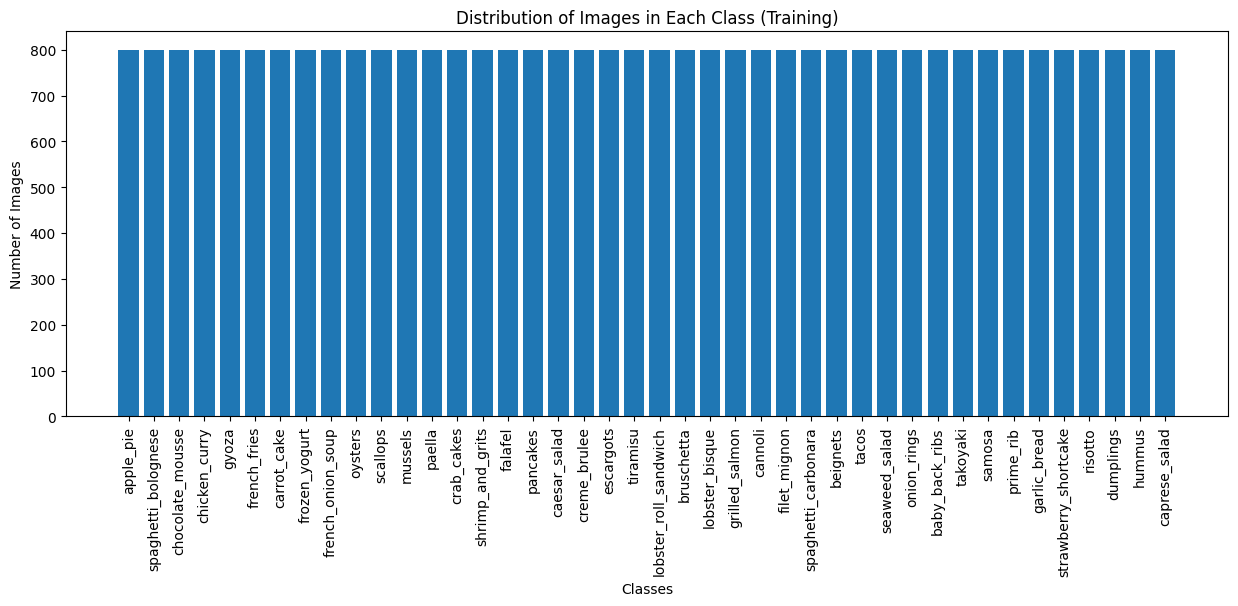

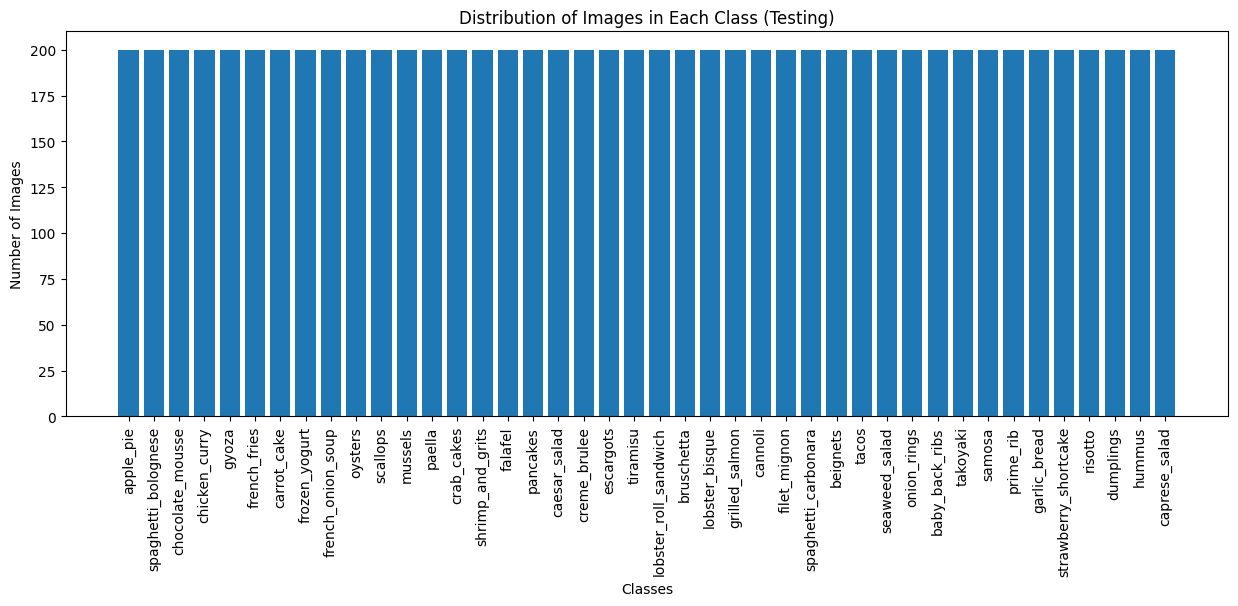

In [ ]:
def plot_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(15, 5))
    plt.bar(classes, counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()

# Plot distribution for training data
plot_distribution(train_class_counts, "Distribution of Images in Each Class (Training)")

# Plot distribution for testing data
plot_distribution(test_class_counts, "Distribution of Images in Each Class (Testing)")


# Defining Data and callBack_List


In [ ]:
from tensorflow.keras import callbacks

callback_list = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=3)
]


#Build and Train the Model using Efficient NetB0

1. Define the base model (EfficientNetB0) with frozen weights
2. Build custom model architecture on top of base_model
3. Instantiate Model_1 for training
4. Compile Model_1 with categorical crossentropy loss and Adam optimizer
5.Train Model_1 on train_ds and validate on val_ds for 6 epochs






In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define the base model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define the model architecture
inputs = Input(shape=(224, 224, 3), name="Input_layer")
x = base_model(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Added Conv2D layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(random_classes), activation="softmax", name="Output_layer")(x)

Model_1 = Model(inputs, outputs)

# Compile the model
Model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Train the model for 6 epochs
Model_1_History = Model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    verbose=1,
    callbacks=callback_list
)


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/6
625/625 [==============================] - 2021s 3s/step - loss: 1.1897 - accuracy: 0.6575 - val_loss: 0.7495 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 2/6
625/625 [==============================] - 2007s 3s/step - loss: 0.7381 - accuracy: 0.7835 - val_loss: 0.7230 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 3/6
625/625 [==============================] - 1965s 3s/step - loss: 0.5893 - accuracy: 0.8263 - val_loss: 0.7102 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 4/6
625/625 [==============================] - 1924s 3s/step - loss: 0.4802 - accuracy: 0.8549 - val_loss: 0.7544 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/6
625/625 [==============================] - 1935s 3s/step - loss: 0.4014 - accuracy: 0.8795 - val_loss: 0.8013 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 6/6
625/625 [==============================] - 1977s 3s/step - loss: 0.3366 - accuracy: 0.8978 - val_loss: 0.8206 - val_accuracy: 0.8028 - lr: 0.0010

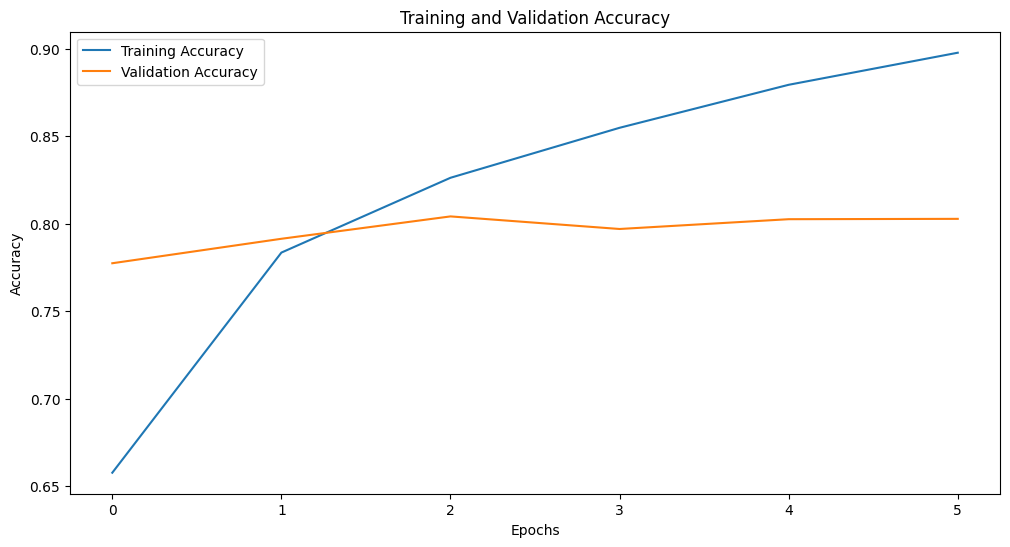

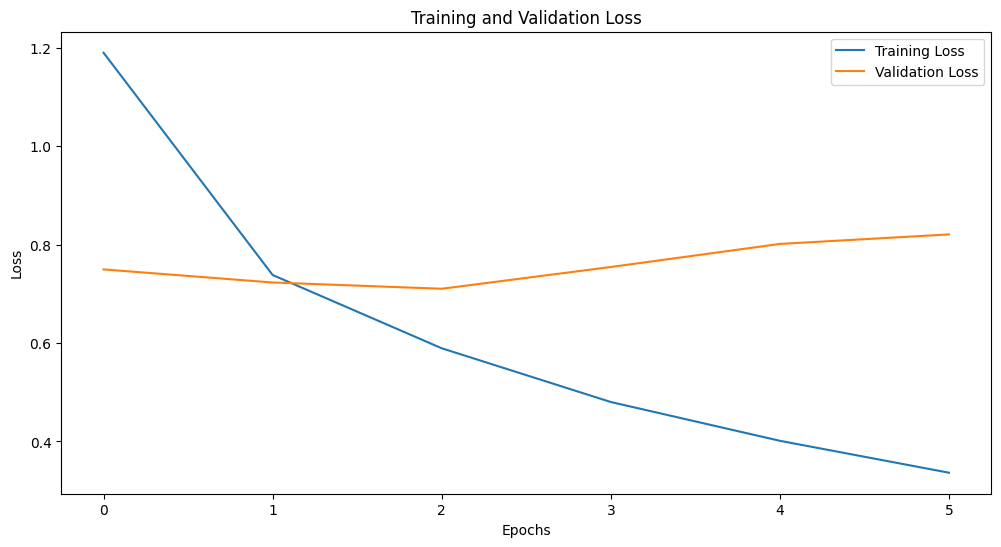

In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(Model_1_History.history['accuracy'], label='Training Accuracy')
plt.plot(Model_1_History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(Model_1_History.history['loss'], label='Training Loss')
plt.plot(Model_1_History.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Conclusion
From the output, we observe that the model has achieved 80% accuracy on the validation dataset. However, the results also indicate that the model is tending towards overfitting, as evidenced by the steadily increasing training accuracy while the validation accuracy does not show corresponding improvement.

To deal with this, we can add regularization parameters and implement several strategies. Here are the steps and methods we can use to address overfitting:

**Unfreezing layers**
  Unfreezing some of the layers of trained models and trained it again

**Add Regularization:**

 1. L2 Regularization (Weight Decay): Penalizes large weights by adding a term to the loss function.
 2. Dropout: Randomly drops a fraction of the units in the network during training.

 **Data Augmentation:**

  Enhance the diversity of the training data without increasing the number of labeled examples.

**Early Stopping:**

  Stop training when the validation loss stops improving, preventing the model from overfitting.

**Reduce Model Complexity: **

  Use a simpler model to prevent overfitting to the training data.
  Increase Training Data:

  Adding more data can help the model generalize better.

**Hyperparameter Tuning:**

  Experiment with different architectures, learning rates, batch sizes, and other hyperparameters.



# Set Up Data Augmentation and Apply it to Training Dataset:
Define an ImageDataGenerator for augmenting training dataset.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_augmented_ds = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical'
)

# Trained the base model by unfreezing the last 10 ayers

In [ ]:
# Un freaze all the Base_model
base_model.trainable = True

#Freezing all the layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Fine-tune Model_2 with augmented data
Model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

Model_1_History_ft = Model_1.fit(
    train_augmented_ds,
    validation_data=val_ds,
    epochs=5,  # Adjust as needed
    verbose=1,
    callbacks=callback_list
)

Epoch 1/5
106/625 [====>.........................] - ETA: 22:17 - loss: 0.6454 - accuracy: 0.8340

# Fine tuning on Resnet

In [ ]:
# Define the base model
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define the model architecture
inputs = Input(shape=(224, 224, 3), name="Input_layer")
x = base_model(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Added Conv2D layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(random_classes), activation="softmax", name="Output_layer")(x)

Model_2 = Model(inputs, outputs)

# Compile the model
Model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Train the model for 6 epochs
Model_2_History = Model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    verbose=1,
    callbacks=callback_list
)

Epoch 1/6
625/625 [==============================] - 5456s 9s/step - loss: 2.3983 - accuracy: 0.2765 - val_loss: 1.8422 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 2/6
625/625 [==============================] - 5360s 9s/step - loss: 1.7557 - accuracy: 0.4500 - val_loss: 1.6803 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 3/6
625/625 [==============================] - ETA: 0s - loss: 1.5141 - accuracy: 0.5283

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_save_path = '/content/drive/My Drive/saved_model/my_model'
Model_1.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/drive/My Drive/saved_model/my_model


In [ ]:
from google.colab import files

# Save the model locally
model_save_path = '/content/my_model'
Model_1.save(model_save_path)

# Zip the saved model directory
!zip -r /content/my_model.zip /content/my_model

# Download the zipped model
files.download('/content/my_model.zip')


  adding: content/my_model/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 91%)
  adding: content/my_model/keras_metadata.pb (deflated 96%)
  adding: content/my_model/fingerprint.pb (stored 0%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_model/variables/variables.index (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model(model_save_path)

# Verify the loaded model by evaluating it on the validation dataset
val_loss, val_acc = loaded_model.evaluate(val_ds)
print(f"Validation Accuracy of loaded model: {val_acc}")

In [ ]:
# Evaluating the model on the validation dataset
val_loss, val_acc = Model_1.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc}")


 91/157 [================>.............] - ETA: 2:42 - loss: 0.8057 - accuracy: 0.8008

**Feature MAP**

In [ ]:

# Define the layers from which we want to extract feature maps
layer_names = [layer.name for layer in Model_1.layers if len(layer.output_shape) == 4]

# Define a new model that outputs feature maps from all convolutional layers
outputs = [Model_1.get_layer(layer_name).output for layer_name in layer_names]
outputs = outputs[-1]
feature_model = Model(inputs=Model_1.input, outputs=outputs)

# Get a batch of images to pass through the model
def get_images_from_dataset(dataset, num_images=1):
    for images, _ in dataset.take(1):
        return images[:num_images]

sample_images = get_images_from_dataset(val_ds, num_images=1)

# Get the feature maps for the sample images
feature_maps = feature_model.predict(sample_images)
print(f"Feature maps shapes: {[feature_map.shape for feature_map in feature_maps]}")

# Function to standardize and normalize feature maps for visualization
def standardize_and_normalize(feature_image):
    feature_image -= feature_image.mean()
    feature_image /= feature_image.std()
    feature_image *= 64
    feature_image += 128
    feature_image = np.clip(feature_image, 0, 255).astype('uint8')
    return feature_image

# Function to plot feature maps
def plot_feature_maps(layer_names, feature_maps):
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if len(feature_map.shape) == 4:
            k = feature_map.shape[-1]
            size = feature_map.shape[1]
            image_belt = np.zeros((size, size * k))

            for i in range(k):
                feature_image = feature_map[0, :, :, i]
                feature_image = standardize_and_normalize(feature_image)
                image_belt[:, i * size : (i + 1) * size] = feature_image

            scale = 20. / k
            plt.figure(figsize=(scale * k, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_belt, aspect='auto')
            plt.show()

# Plot feature maps
plot_feature_maps(layer_names, feature_maps)


**Unfreeze Last 10 Layers and Fine-Tune the Model**

## below No use of  code